In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
svr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_SVR"
svr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD & CLEAN DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
].copy()

df.rename(columns={
    "Scour_Depth_mm": "Scour",
    "Vy_kN": "Vy",
    "dy_mm": "Dy",
    "My_kNm": "My",
    "Thy_rad": "Thy"
}, inplace=True)

# --- FILTER OUTLIERS BASED ON ALL TUPLES (IQR method) ---
bins = np.arange(0, df["Scour"].max() + 250, 250)
labels = (bins[:-1] + bins[1:]) / 2
df["Scour_Bin"] = pd.cut(df["Scour"], bins=bins, labels=labels)

def filter_by_iqr_all(group):
    mask = np.ones(len(group), dtype=bool)
    for col in ["Vy", "Dy", "My", "Thy"]:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        mask &= (group[col] >= q1) & (group[col] <= q3)
    return group[mask]

df_filtered = df.groupby("Scour_Bin", group_keys=False).apply(filter_by_iqr_all)

# --- FEATURE ENGINEERING ---
df_filtered["Scour2"] = df_filtered["Scour"] ** 2
df_filtered["Scour3"] = df_filtered["Scour"] ** 3
df_filtered["invScour"] = 1 / df_filtered["Scour"]
df_filtered["logScour"] = np.log(df_filtered["Scour"])
df_filtered["sqrtScour"] = np.sqrt(df_filtered["Scour"])

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
targets = ["Vy", "Dy", "My", "Thy"]
summary = []

n_credal = 30  # Number of bootstrap models

for target in targets:
    X = df_filtered[features].values
    y = df_filtered[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # --- Scale both X and y ---
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

    # Save scalers
    joblib.dump(x_scaler, svr_folder / f"x_scaler_{target}.pkl")
    joblib.dump(y_scaler, svr_folder / f"y_scaler_{target}.pkl")

    # === CREDAL SET SVR ===
    y_preds = []
    for i in range(n_credal):
        X_res, y_res = resample(X_train_scaled, y_train_scaled, replace=True, random_state=i)
        model = SVR(
            kernel='rbf',
            C=100.0,
            epsilon=0.01,
            gamma='scale',
            shrinking=True,
            tol=1e-4,
            cache_size=500
        )
        model.fit(X_res, y_res)
        joblib.dump(model, svr_folder / f"credal_svr_model_{target}_boot{i}.pkl")
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_preds.append(y_pred)

    # Stack predictions and compute min–max credal bounds
    y_preds_stack = np.vstack(y_preds)
    y_lower = np.min(y_preds_stack, axis=0)
    y_upper = np.max(y_preds_stack, axis=0)
    y_median = np.median(y_preds_stack, axis=0)

    # Save credal bounds predictions
    df_credal = pd.DataFrame({
        "Actual": y_test,
        "LowerBound": y_lower,
        "UpperBound": y_upper,
        "MedianPrediction": y_median
    })
    df_credal.to_excel(svr_folder / f"Credal_Bounds_{target}.xlsx", index=False)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_median, color='blue', s=30, label="Median Prediction", alpha=0.6)
    plt.fill_between(np.arange(len(y_test)), y_lower, y_upper, alpha=0.3, label="Credal Bounds [min–max]")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"SVR Credal Bounds for {target}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(svr_folder / f"Credal_Bounds_{target}.png", dpi=300)
    plt.close()

    r2 = r2_score(y_test, y_median)
    rmse = mean_squared_error(y_test, y_median, squared=False)
    summary.append({"Target": target, "R2": r2, "RMSE": rmse})

    print(f"✅ SVR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
df_summary.to_excel(base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_SVR_Filtered_AllTuples.xlsx", index=False)

print("\n📄 All SVR credal models trained, filtered, bounds saved, and plots generated (Min–Max credal set).")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ SVR trained for Vy | R² = 0.887, RMSE = 93.439
✅ SVR trained for Dy | R² = 0.981, RMSE = 4.897
✅ SVR trained for My | R² = 0.737, RMSE = 781.992
✅ SVR trained for Thy | R² = 0.968, RMSE = 0.000

📄 All SVR credal models trained, filtered, bounds saved, and plots generated (Min–Max credal set).


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
gbr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal"
gbr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD & CLEAN DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
].copy()

df.rename(columns={
    "Scour_Depth_mm": "Scour",
    "Vy_kN": "Vy",
    "dy_mm": "Dy",
    "My_kNm": "My",
    "Thy_rad": "Thy"
}, inplace=True)

# --- FILTER OUTLIERS BASED ON ALL TUPLES ---
bins = np.arange(0, df["Scour"].max() + 250, 250)
labels = (bins[:-1] + bins[1:]) / 2
df["Scour_Bin"] = pd.cut(df["Scour"], bins=bins, labels=labels)

def filter_by_iqr_all(group):
    mask = np.ones(len(group), dtype=bool)
    for col in ["Vy", "Dy", "My", "Thy"]:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        mask &= (group[col] >= q1) & (group[col] <= q3)
    return group[mask]

df_filtered = df.groupby("Scour_Bin", group_keys=False).apply(filter_by_iqr_all)

# --- FEATURE ENGINEERING ---
df_filtered["Scour2"] = df_filtered["Scour"] ** 2
df_filtered["Scour3"] = df_filtered["Scour"] ** 3
df_filtered["invScour"] = 1 / df_filtered["Scour"]
df_filtered["logScour"] = np.log(df_filtered["Scour"])
df_filtered["sqrtScour"] = np.sqrt(df_filtered["Scour"])

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
targets = ["Vy", "Dy", "My", "Thy"]
summary = []

n_credal = 30  # Number of bootstrap models

for target in targets:
    X = df_filtered[features].values
    y = df_filtered[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # === CREDAL SET GBR ===
    y_preds = []
    for i in range(n_credal):
        X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
        model = GradientBoostingRegressor(
            n_estimators=700,
            max_depth=3,
            learning_rate=0.015,
            subsample=0.85,
            random_state=i
        )
        model.fit(X_res, y_res)
        joblib.dump(model, gbr_folder / f"credal_model_{target}_boot{i}.pkl")
        y_preds.append(model.predict(X_test))

    y_preds_stack = np.vstack(y_preds)
    y_lower = np.min(y_preds_stack, axis=0)  # Min–Max bounds
    y_upper = np.max(y_preds_stack, axis=0)
    y_median = np.median(y_preds_stack, axis=0)

    # Save credal bounds predictions
    df_credal = pd.DataFrame({
        "Actual": y_test,
        "LowerBound": y_lower,
        "UpperBound": y_upper,
        "MedianPrediction": y_median
    })
    df_credal.to_excel(gbr_folder / f"Credal_Bounds_{target}.xlsx", index=False)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_median, color='blue', s=30, label="Median Prediction", alpha=0.6)
    plt.fill_between(np.arange(len(y_test)), y_lower, y_upper, alpha=0.3, label="Credal Bounds [min–max]")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"GBR Credal Bounds for {target}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(gbr_folder / f"Credal_Bounds_{target}.png", dpi=300)
    plt.close()

    r2 = r2_score(y_test, y_median)
    rmse = mean_squared_error(y_test, y_median, squared=False)
    summary.append({"Target": target, "R2": r2, "RMSE": rmse})

    print(f"✅ GBR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
df_summary.to_excel(base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_GBR_Filtered_AllTuples.xlsx", index=False)

print("\n📄 All GBR credal models trained, bounds saved, and plots generated (Min–Max credal set).")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ GBR trained for Vy | R² = 0.745, RMSE = 140.199
✅ GBR trained for Dy | R² = 0.992, RMSE = 3.195
✅ GBR trained for My | R² = 0.727, RMSE = 796.789
✅ GBR trained for Thy | R² = 0.970, RMSE = 0.000

📄 All GBR credal models trained, bounds saved, and plots generated (Min–Max credal set).


FileNotFoundError: [Errno 2] No such file or directory: 'RecorderData\\results\\Tuple_Data_Process\\ML_Surrogate_Credal_SVR\\x_scaler_Vy.pkl'

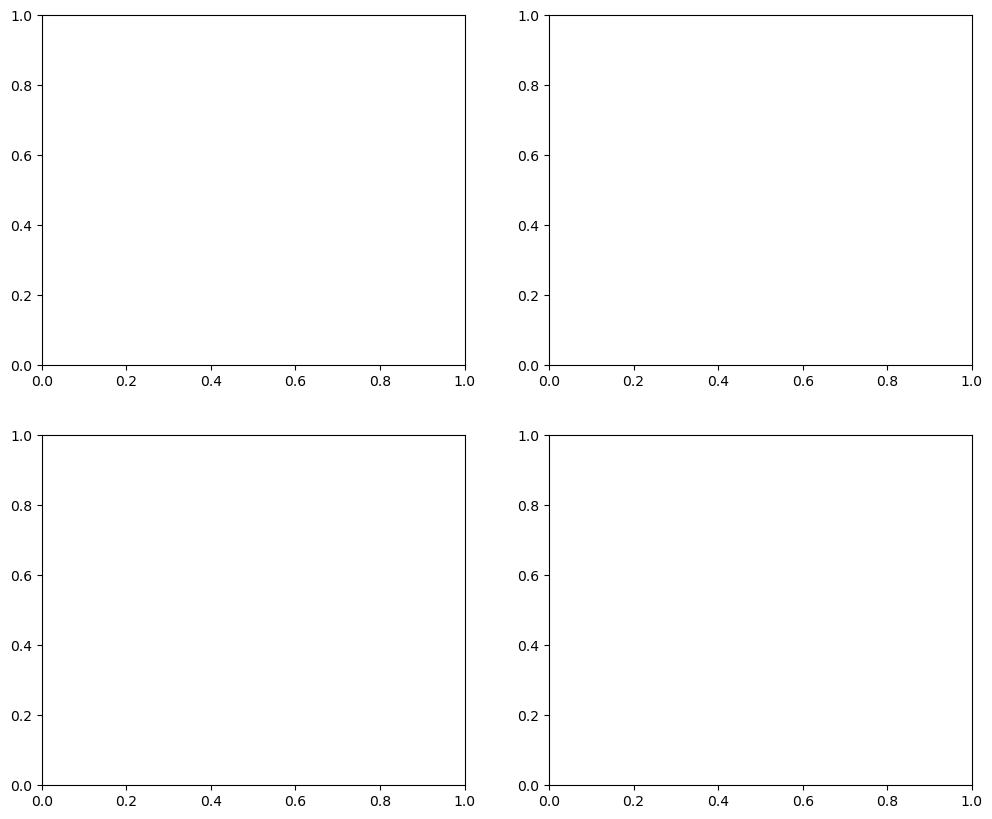

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# --- CONFIGURATION ---
base_folder = Path("RecorderData/results/Tuple_Data_Process")
combined_folder = Path("RecorderData/results/Credal_Plots_Combined")
combined_folder.mkdir(parents=True, exist_ok=True)

targets = ["Vy", "Dy", "My", "Thy"]
colors = {"Vy": "blue", "Dy": "green", "My": "red", "Thy": "magenta"}
model_types = {
    "GBR": base_folder / "ML_Surrogate_Credal",
    "SVR": base_folder / "ML_Surrogate_Credal_SVR"
}

# --- FEATURE TRANSFORMATION ---
def transform_features(scour_depths):
    scour_depths = np.atleast_1d(scour_depths)
    return np.column_stack([
        scour_depths,
        scour_depths**2,
        scour_depths**3,
        np.log(scour_depths),
        1 / scour_depths,
        np.sqrt(scour_depths)
    ])

# --- SCOUR RANGE ---
scour_depths = np.linspace(1, 14000, 100)
X_raw = transform_features(scour_depths)

# --- CREDAL SET PREDICTION FUNCTION ---
def predict_credal_bounds(target, model_type):
    model_folder = model_types[model_type]
    preds = []

    for i in range(5):
        if model_type == "SVR":
            model_path = model_folder / f"credal_svr_model_{target}_boot{i}.pkl"
            x_scaler_path = model_folder / f"x_scaler_{target}.pkl"
            y_scaler_path = model_folder / f"y_scaler_{target}.pkl"

            x_scaler = joblib.load(x_scaler_path)
            y_scaler = joblib.load(y_scaler_path)
            model = joblib.load(model_path)

            X_scaled = x_scaler.transform(X_raw)
            y_pred_scaled = model.predict(X_scaled)
            y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        else:
            model_path = model_folder / f"credal_model_{target}_boot{i}.pkl"
            model = joblib.load(model_path)
            y_pred = model.predict(X_raw)

        preds.append(y_pred)

    preds = np.vstack(preds)
    return np.min(preds, axis=0), np.max(preds, axis=0), np.median(preds, axis=0)

# --- PLOT FOR BOTH MODELS ---
for model_type in model_types:
    # --- CREDAL BOUNDS PLOT ---
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    for i, target in enumerate(targets):
        y_lower, y_upper, y_median = predict_credal_bounds(target, model_type)
        ax = axs[i]
        ax.plot(scour_depths, y_median, color=colors[target], label=f"Median {target}")
        ax.fill_between(scour_depths, y_lower, y_upper, color=colors[target], alpha=0.3, label="Credal Bounds")
        ax.set_xlabel("Scour Depth (mm)")
        ax.set_ylabel(target + (" (kN)" if target == "Vy" else " (mm)" if target == "Dy" else " (kN·m)" if target == "My" else " (rad)"))
        ax.set_title(f"{target} vs. Scour Depth ({model_type})")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"{model_type} Credal Set Bounds vs. Scour Depth", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    bounds_path = combined_folder / f"{model_type}_Credal_Bounds_Curves.png"
    plt.savefig(bounds_path, dpi=300)
    plt.close()

    # --- UNCERTAINTY WIDTH PLOT ---
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    for i, target in enumerate(targets):
        y_lower, y_upper, _ = predict_credal_bounds(target, model_type)
        width = y_upper - y_lower
        ax = axs[i]
        ax.plot(scour_depths, width, color=colors[target], label="Uncertainty Width")
        ax.set_xlabel("Scour Depth (mm)")
        ax.set_ylabel("Width")
        ax.set_title(f"Width vs. Scour Depth ({target}, {model_type})")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"{model_type} Credal Uncertainty Width vs. Scour Depth", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    width_path = combined_folder / f"{model_type}_Credal_Uncertainty_Widths.png"
    plt.savefig(width_path, dpi=300)
    plt.close()

print("✅ All corrected SVR and GBR plots saved in:", combined_folder)


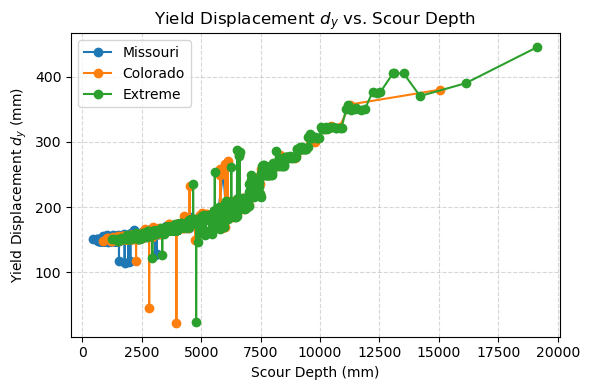

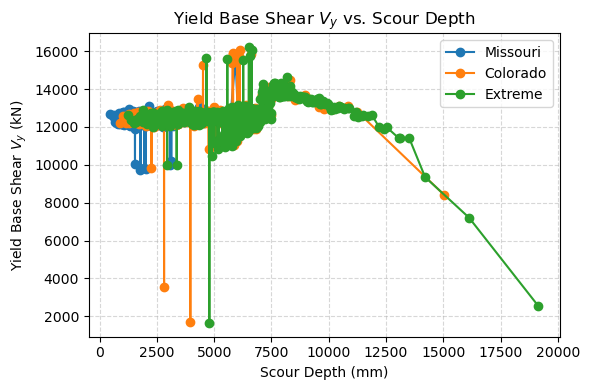

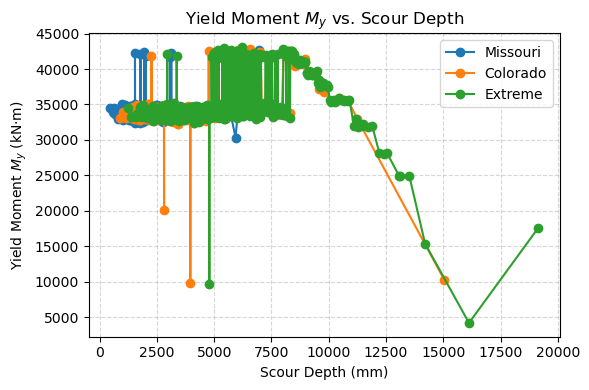

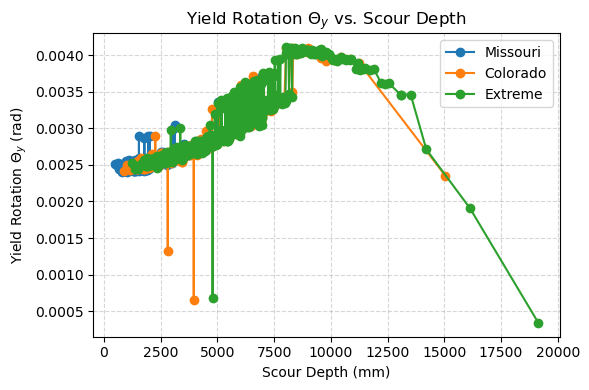

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load the Excel produced by the script ===
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
if not excel_path.exists():
    raise FileNotFoundError("Yield_Results_by_Scenario.xlsx not found in RecorderData/.")

sheets = pd.read_excel(excel_path, sheet_name=None)

# Variables to plot
variables = {
    "dy_mm": ("Yield Displacement $d_y$ (mm)", "Scour_vs_dy.png"),
    "Vy_kN": ("Yield Base Shear $V_y$ (kN)", "Scour_vs_Vy.png"),
    "My_kNm": ("Yield Moment $M_y$ (kN·m)", "Scour_vs_My.png"),
    "Thy_rad": ("Yield Rotation $\\Theta_y$ (rad)", "Scour_vs_Thy.png")
}

for var, (ylabel, fname) in variables.items():
    plt.figure(figsize=(6, 4))
    for scenario, df in sheets.items():
        plt.plot(
            df["Scour_Depth_mm"],
            df[var],
            marker="o",
            linestyle="-",
            label=scenario
        )
    plt.xlabel("Scour Depth (mm)")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel.split(' (')[0]} vs. Scour Depth")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path("RecorderData/") / fname)
    plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
raw_svr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_SVR_raw"
raw_svr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD & CLEAN DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
].copy()
df.rename(columns={
    "Scour_Depth_mm": "Scour",
    "Vy_kN": "Vy",
    "dy_mm": "Dy",
    "My_kNm": "My",
    "Thy_rad": "Thy"
}, inplace=True)

# --- NO FILTER: use all rows directly ---
df_filtered = df.copy()

# --- FEATURE ENGINEERING ---
df_filtered["Scour2"]    = df_filtered["Scour"] ** 2
df_filtered["Scour3"]    = df_filtered["Scour"] ** 3
df_filtered["invScour"]  = 1.0 / df_filtered["Scour"]
df_filtered["logScour"]  = np.log(df_filtered["Scour"])
df_filtered["sqrtScour"] = np.sqrt(df_filtered["Scour"])

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
targets  = ["Vy", "Dy", "My", "Thy"]
summary  = []

n_credal = 30  # Number of bootstrap models

for target in targets:
    # Split
    X = df_filtered[features].values
    y = df_filtered[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )

    # Scale X and y
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled  = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

    # Save scalers
    joblib.dump(x_scaler, raw_svr_folder / f"x_scaler_{target}.pkl")
    joblib.dump(y_scaler, raw_svr_folder / f"y_scaler_{target}.pkl")

    # === CREDAL SET SVR BOOTSTRAPS ===
    y_preds = []
    for i in range(n_credal):
        X_res, y_res = resample(
            X_train_scaled, y_train_scaled,
            replace=True, random_state=i
        )
        model = SVR(
            kernel='rbf', C=100.0, epsilon=0.01,
            gamma='scale', shrinking=True,
            tol=1e-4, cache_size=500
        )
        model.fit(X_res, y_res)
        joblib.dump(model, raw_svr_folder / f"credal_svr_{target}_boot{i}.pkl")

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_preds.append(y_pred)

    # Compute credal bounds
    y_stack  = np.vstack(y_preds)
    y_lower  = np.min(y_stack, axis=0)
    y_upper  = np.max(y_stack, axis=0)
    y_median = np.median(y_stack, axis=0)

    # Save bounds to Excel
    df_bounds = pd.DataFrame({
        "Actual":          y_test,
        "LowerBound":      y_lower,
        "UpperBound":      y_upper,
        "MedianPrediction": y_median
    })
    df_bounds.to_excel(
        raw_svr_folder / f"Credal_Bounds_{target}_raw.xlsx",
        index=False
    )

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
    plt.fill_between(
        np.arange(len(y_test)), y_lower, y_upper,
        alpha=0.3, label="Credal Bounds [min–max]"
    )
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"SVR Credal Bounds for {target} (raw)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        raw_svr_folder / f"Credal_Bounds_{target}_raw.png",
        dpi=300
    )
    plt.close()

    # Metrics
    r2   = r2_score(y_test, y_median)
    rmse = mean_squared_error(y_test, y_median, squared=False)
    summary.append({"Target": target, "R2": r2, "RMSE": rmse})

    print(f"✅ SVR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_SVR_Raw.xlsx"
summary_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 All SVR credal models trained on raw data. Results in:\n  {raw_svr_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ SVR trained for Vy | R² = 0.495, RMSE = 245.003
✅ SVR trained for Dy | R² = 0.970, RMSE = 5.514
✅ SVR trained for My | R² = 0.384, RMSE = 1396.730
✅ SVR trained for Thy | R² = 0.916, RMSE = 0.000

📄 All SVR credal models trained on raw data. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_SVR_raw
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_SVR_Raw.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
gbr_raw_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_raw"
gbr_raw_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD & CLEAN DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
].copy()

df.rename(columns={
    "Scour_Depth_mm": "Scour",
    "Vy_kN": "Vy",
    "dy_mm": "Dy",
    "My_kNm": "My",
    "Thy_rad": "Thy"
}, inplace=True)

# --- NO FILTER: use all cleaned rows ---
df_filtered = df.copy()

# --- FEATURE ENGINEERING ---
df_filtered["Scour2"]    = df_filtered["Scour"] ** 2
df_filtered["Scour3"]    = df_filtered["Scour"] ** 3
df_filtered["invScour"]  = 1.0 / df_filtered["Scour"]
df_filtered["logScour"]  = np.log(df_filtered["Scour"])
df_filtered["sqrtScour"] = np.sqrt(df_filtered["Scour"])

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
targets  = ["Vy", "Dy", "My", "Thy"]
summary  = []

n_credal = 30  # Number of bootstrap models

for target in targets:
    # prepare data
    X = df_filtered[features].values
    y = df_filtered[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )

    # === CREDAL SET GBR ===
    y_preds = []
    for i in range(n_credal):
        X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
        model = GradientBoostingRegressor(
            n_estimators=700,
            max_depth=3,
            learning_rate=0.015,
            subsample=0.85,
            random_state=i
        )
        model.fit(X_res, y_res)
        joblib.dump(model, gbr_raw_folder / f"credal_model_{target}_boot{i}_raw.pkl")
        y_preds.append(model.predict(X_test))

    # stack and compute bounds
    y_stack  = np.vstack(y_preds)
    y_lower  = y_stack.min(axis=0)
    y_upper  = y_stack.max(axis=0)
    y_median = np.median(y_stack, axis=0)

    # save bounds
    df_bounds = pd.DataFrame({
        "Actual":           y_test,
        "LowerBound":       y_lower,
        "UpperBound":       y_upper,
        "MedianPrediction": y_median
    })
    df_bounds.to_excel(
        gbr_raw_folder / f"Credal_Bounds_{target}_raw.xlsx", index=False
    )

    # plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
    plt.fill_between(
        np.arange(len(y_test)), y_lower, y_upper,
        alpha=0.3, label="Credal Bounds [min–max]"
    )
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"GBR Credal Bounds for {target} (raw)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        gbr_raw_folder / f"Credal_Bounds_{target}_raw.png", dpi=300
    )
    plt.close()

    # metrics
    r2   = r2_score(y_test, y_median)
    rmse = mean_squared_error(y_test, y_median, squared=False)
    summary.append({"Target": target, "R2": r2, "RMSE": rmse})

    print(f"✅ GBR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_GBR_Raw.xlsx"
summary_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 All GBR credal models trained on raw data. Results in:\n  {gbr_raw_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ GBR trained for Vy | R² = 0.501, RMSE = 243.576
✅ GBR trained for Dy | R² = 0.986, RMSE = 3.819
✅ GBR trained for My | R² = 0.417, RMSE = 1358.036
✅ GBR trained for Thy | R² = 0.922, RMSE = 0.000

📄 All GBR credal models trained on raw data. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_raw
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_GBR_Raw.xlsx


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
k2_svr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_SVR_K2_raw"
k2_svr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0)
].copy()

# --- FEATURE ENGINEERING ---
df.rename(columns={"Scour_Depth_mm": "Scour"}, inplace=True)
df["Scour2"]    = df["Scour"] ** 2
df["Scour3"]    = df["Scour"] ** 3
df["invScour"]  = 1.0 / df["Scour"]
df["logScour"]  = np.log(df["Scour"])
df["sqrtScour"] = np.sqrt(df["Scour"])

# --- DEFINE TARGET ---
if "K2" not in df.columns:
    # ❗ If K2 not exist, you need to define it. Placeholder:
    df["K2"] = 0.5 * df["Scour"] ** 0.3  # Example formula; you should replace with real K2 if available

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
target = "K2"
summary = []

# --- TRAIN SVR MODELS (CREDAL SET) ---
n_credal = 30

X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Scale X and y
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

# Save scalers
joblib.dump(x_scaler, k2_svr_folder / f"x_scaler_{target}.pkl")
joblib.dump(y_scaler, k2_svr_folder / f"y_scaler_{target}.pkl")

# Bootstrap
y_preds = []
for i in range(n_credal):
    X_res, y_res = resample(X_train_scaled, y_train_scaled, replace=True, random_state=i)
    model = SVR(
        kernel='rbf', C=100.0, epsilon=0.01,
        gamma='scale', shrinking=True,
        tol=1e-4, cache_size=500
    )
    model.fit(X_res, y_res)
    joblib.dump(model, k2_svr_folder / f"credal_svr_{target}_boot{i}.pkl")

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_preds.append(y_pred)

# Credal bounds
y_stack  = np.vstack(y_preds)
y_lower  = np.min(y_stack, axis=0)
y_upper  = np.max(y_stack, axis=0)
y_median = np.median(y_stack, axis=0)

# Save bounds to Excel
df_bounds = pd.DataFrame({
    "Actual":          y_test,
    "LowerBound":      y_lower,
    "UpperBound":      y_upper,
    "MedianPrediction": y_median
})
df_bounds.to_excel(
    k2_svr_folder / f"Credal_Bounds_{target}_raw.xlsx",
    index=False
)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
plt.fill_between(
    np.arange(len(y_test)), y_lower, y_upper,
    alpha=0.3, label="Credal Bounds [min–max]"
)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
plt.xlabel(f"Actual {target}")
plt.ylabel(f"Predicted {target}")
plt.title(f"SVR Credal Bounds for {target} (raw)")
plt.legend()
plt.tight_layout()
plt.savefig(
    k2_svr_folder / f"Credal_Bounds_{target}_raw.png",
    dpi=300
)
plt.close()

# Metrics
r2   = r2_score(y_test, y_median)
rmse = mean_squared_error(y_test, y_median, squared=False)
summary.append({"Target": target, "R2": r2, "RMSE": rmse})

print(f"✅ SVR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_SVR_K2_Raw.xlsx"
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 SVR credal models for {target} completed. Results in:\n  {k2_svr_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ SVR trained for K2 | R² = 0.979, RMSE = 0.131

📄 SVR credal models for K2 completed. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_SVR_K2_raw
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_SVR_K2_Raw.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
gbr_k2_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_GBR_K2_raw"
gbr_k2_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0)
].copy()

# --- FEATURE ENGINEERING ---
df.rename(columns={"Scour_Depth_mm": "Scour"}, inplace=True)
df["Scour2"]    = df["Scour"] ** 2
df["Scour3"]    = df["Scour"] ** 3
df["invScour"]  = 1.0 / df["Scour"]
df["logScour"]  = np.log(df["Scour"])
df["sqrtScour"] = np.sqrt(df["Scour"])

# --- DEFINE TARGET ---
if "K2" not in df.columns:
    # ❗ If K2 does not exist, define it temporarily
    df["K2"] = 0.5 * df["Scour"] ** 0.3  # Example; change this based on your actual K2 formula

features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
target = "K2"
summary = []

# --- TRAIN GBR MODELS (CREDAL SET) ---
n_credal = 30

X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Bootstrap
y_preds = []
for i in range(n_credal):
    X_res, y_res = resample(X_train, y_train, replace=True, random_state=i)
    model = GradientBoostingRegressor(
        n_estimators=700,
        max_depth=3,
        learning_rate=0.015,
        subsample=0.85,
        random_state=i
    )
    model.fit(X_res, y_res)
    joblib.dump(model, gbr_k2_folder / f"credal_gbr_{target}_boot{i}.pkl")
    y_preds.append(model.predict(X_test))

# Credal bounds
y_stack  = np.vstack(y_preds)
y_lower  = np.min(y_stack, axis=0)
y_upper  = np.max(y_stack, axis=0)
y_median = np.median(y_stack, axis=0)

# Save bounds to Excel
df_bounds = pd.DataFrame({
    "Actual":          y_test,
    "LowerBound":      y_lower,
    "UpperBound":      y_upper,
    "MedianPrediction": y_median
})
df_bounds.to_excel(
    gbr_k2_folder / f"Credal_Bounds_{target}_raw.xlsx",
    index=False
)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
plt.fill_between(
    np.arange(len(y_test)), y_lower, y_upper,
    alpha=0.3, label="Credal Bounds [min–max]"
)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
plt.xlabel(f"Actual {target}")
plt.ylabel(f"Predicted {target}")
plt.title(f"GBR Credal Bounds for {target} (raw)")
plt.legend()
plt.tight_layout()
plt.savefig(
    gbr_k2_folder / f"Credal_Bounds_{target}_raw.png",
    dpi=300
)
plt.close()

# Metrics
r2   = r2_score(y_test, y_median)
rmse = mean_squared_error(y_test, y_median, squared=False)
summary.append({"Target": target, "R2": r2, "RMSE": rmse})

print(f"✅ GBR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_GBR_K2_Raw.xlsx"
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 GBR credal models for {target} completed. Results in:\n  {gbr_k2_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ GBR trained for K2 | R² = 0.999, RMSE = 0.023

📄 GBR credal models for K2 completed. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_GBR_K2_raw
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_GBR_K2_Raw.xlsx


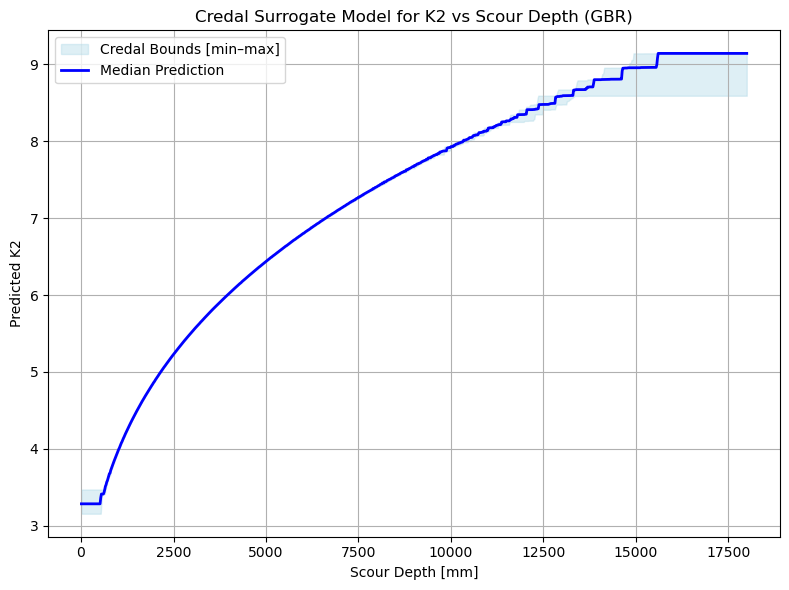

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# --- Setup ---
folder_path = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_GBR_K2_raw")
n_bootstrap = 30  # how many bootstraps you trained
scour_range = np.linspace(10, 18000, 1000)  # 10 mm to 20000 mm

# --- Build input feature matrix ---
X_features = np.column_stack([
    scour_range,
    scour_range**2,
    scour_range**3,
    np.log(scour_range),
    1.0/scour_range,
    np.sqrt(scour_range)
])

# --- Predict K2 across all bootstraps ---
k2_preds = []
for i in range(n_bootstrap):
    model_path = folder_path / f"credal_gbr_K2_boot{i}.pkl"
    model = joblib.load(model_path)
    k2_pred = model.predict(X_features)
    k2_preds.append(k2_pred)

# Stack predictions
k2_preds = np.vstack(k2_preds)  # shape (n_bootstrap, n_points)

# Compute bounds
k2_lower = np.min(k2_preds, axis=0)
k2_upper = np.max(k2_preds, axis=0)
k2_median = np.median(k2_preds, axis=0)

# --- Plot ---
plt.figure(figsize=(8,6))

# Fill between lower and upper bounds
plt.fill_between(scour_range, k2_lower, k2_upper, color='lightblue', alpha=0.4, label="Credal Bounds [min–max]")

# Plot median prediction
plt.plot(scour_range, k2_median, label="Median Prediction", color='blue', lw=2)

plt.xlabel("Scour Depth [mm]")
plt.ylabel("Predicted K2")
plt.title("Credal Surrogate Model for K2 vs Scour Depth (GBR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


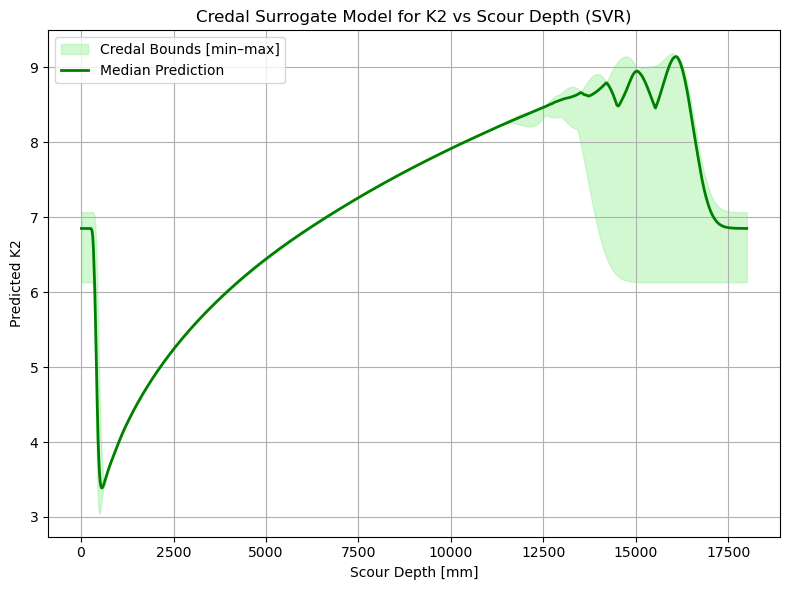

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# --- Setup ---
folder_path = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR_K2_raw")
n_bootstrap = 30  # number of bootstraps you trained

# Load scalers (you saved them during training)
x_scaler = joblib.load(folder_path / "x_scaler_K2.pkl")
y_scaler = joblib.load(folder_path / "y_scaler_K2.pkl")

# Build Scour input range
scour_range = np.linspace(10, 18000, 1000)

# Build raw feature matrix
X_raw = np.column_stack([
    scour_range,
    scour_range**2,
    scour_range**3,
    np.log(scour_range),
    1.0/scour_range,
    np.sqrt(scour_range)
])

# Scale X
X_scaled = x_scaler.transform(X_raw)

# --- Predict K2 across all SVR bootstraps ---
k2_preds = []
for i in range(n_bootstrap):
    model_path = folder_path / f"credal_svr_K2_boot{i}.pkl"
    model = joblib.load(model_path)
    
    k2_pred_scaled = model.predict(X_scaled)
    k2_pred = y_scaler.inverse_transform(k2_pred_scaled.reshape(-1,1)).ravel()
    k2_preds.append(k2_pred)

# Stack predictions
k2_preds = np.vstack(k2_preds)

# Compute bounds
k2_lower = np.min(k2_preds, axis=0)
k2_upper = np.max(k2_preds, axis=0)
k2_median = np.median(k2_preds, axis=0)

# --- Plot ---
plt.figure(figsize=(8,6))

# Fill between lower and upper bounds
plt.fill_between(scour_range, k2_lower, k2_upper, color='lightgreen', alpha=0.4, label="Credal Bounds [min–max]")

# Plot median prediction
plt.plot(scour_range, k2_median, label="Median Prediction", color='green', lw=2)

plt.xlabel("Scour Depth [mm]")
plt.ylabel("Predicted K2")
plt.title("Credal Surrogate Model for K2 vs Scour Depth (SVR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
k2_svr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_SVR_K2_raw"
k2_svr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0)
].copy()

# --- FEATURE ENGINEERING ---
df.rename(columns={"Scour_Depth_mm": "Scour"}, inplace=True)
df["Scour2"]    = df["Scour"] ** 2
df["Scour3"]    = df["Scour"] ** 3
df["invScour"]  = 1.0 / df["Scour"]
df["logScour"]  = np.log(df["Scour"])
df["sqrtScour"] = np.sqrt(df["Scour"])

# --- DEFINE TARGET ---
if "K2" not in df.columns:
    # ❗ If K2 not exist, you need to define it. Placeholder:
    df["K2"] = 0.5 * df["Scour"] ** 0.3  # Example formula; you should replace with real K2 if available

features = [
    # "Scour", "Scour2", "Scour3", 
            "logScour"
            # , "invScour", "sqrtScour"
]
target = "K2"
summary = []

# --- TRAIN SVR MODELS (CREDAL SET) ---
n_credal = 30

X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Scale X and y
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

# Save scalers
joblib.dump(x_scaler, k2_svr_folder / f"x_scaler_{target}.pkl")
joblib.dump(y_scaler, k2_svr_folder / f"y_scaler_{target}.pkl")

# Bootstrap
y_preds = []
for i in range(n_credal):
    X_res, y_res = resample(X_train_scaled, y_train_scaled, replace=True, random_state=i)
    model = SVR(
        kernel='rbf', C=100.0, epsilon=0.01,
        gamma='scale', shrinking=True,
        tol=1e-4, cache_size=500
    )
    model.fit(X_res, y_res)
    joblib.dump(model, k2_svr_folder / f"credal_svr_{target}_boot{i}.pkl")

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_preds.append(y_pred)

# Credal bounds
y_stack  = np.vstack(y_preds)
y_lower  = np.min(y_stack, axis=0)
y_upper  = np.max(y_stack, axis=0)
y_median = np.median(y_stack, axis=0)

# Save bounds to Excel
df_bounds = pd.DataFrame({
    "Actual":          y_test,
    "LowerBound":      y_lower,
    "UpperBound":      y_upper,
    "MedianPrediction": y_median
})
df_bounds.to_excel(
    k2_svr_folder / f"Credal_Bounds_{target}_raw.xlsx",
    index=False
)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
plt.fill_between(
    np.arange(len(y_test)), y_lower, y_upper,
    alpha=0.3, label="Credal Bounds [min–max]"
)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
plt.xlabel(f"Actual {target}")
plt.ylabel(f"Predicted {target}")
plt.title(f"SVR Credal Bounds for {target} (raw)")
plt.legend()
plt.tight_layout()
plt.savefig(
    k2_svr_folder / f"Credal_Bounds_{target}_raw.png",
    dpi=300
)
plt.close()

# Metrics
r2   = r2_score(y_test, y_median)
rmse = mean_squared_error(y_test, y_median, squared=False)
summary.append({"Target": target, "R2": r2, "RMSE": rmse})

print(f"✅ SVR trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_SVR_K2_Raw.xlsx"
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 SVR credal models for {target} completed. Results in:\n  {k2_svr_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ SVR trained for K2 | R² = 1.000, RMSE = 0.016

📄 SVR credal models for K2 completed. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_SVR_K2_raw
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_SVR_K2_Raw.xlsx


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import copy
from pathlib import Path
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
excel_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
base_folder = Path("RecorderData/results")
raw_svr_folder = base_folder / "Tuple_Data_Process" / "ML_Surrogate_Credal_SVR_raw_ScourOnly"
raw_svr_folder.mkdir(parents=True, exist_ok=True)

print(f"📂 Loaded: {excel_path.name}")

# --- LOAD & CLEAN DATA ---
df_all = pd.concat(pd.read_excel(excel_path, sheet_name=None), ignore_index=True)
df = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
].copy()
df.rename(columns={
    "Scour_Depth_mm": "Scour",
    "Vy_kN": "Vy",
    "dy_mm": "Dy",
    "My_kNm": "My",
    "Thy_rad": "Thy"
}, inplace=True)

# --- NO FEATURE ENGINEERING ---
features = ["Scour"]
targets  = ["Vy", "Dy", "My", "Thy"]
kernels  = {
    "rbf": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1),
    "linear": SVR(kernel="linear", C=100, gamma="auto"),
    "poly": SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
}

n_credal = 30  # Number of bootstrap models
summary  = []

# --- MAIN LOOP ---
for target in targets:
    X = df[features].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # Scale
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled  = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

    # Save scalers
    joblib.dump(x_scaler, raw_svr_folder / f"x_scaler_{target}.pkl")
    joblib.dump(y_scaler, raw_svr_folder / f"y_scaler_{target}.pkl")

    for kernel_name, svr_base in kernels.items():
        y_preds = []
        for i in range(n_credal):
            X_res, y_res = resample(X_train_scaled, y_train_scaled, replace=True, random_state=i)
            svr = copy.deepcopy(svr_base)  # ✅ correct
            svr.fit(X_res, y_res)
            joblib.dump(svr, raw_svr_folder / f"credal_svr_{target}_{kernel_name}_boot{i}.pkl")

            y_pred_scaled = svr.predict(X_test_scaled)
            y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            y_preds.append(y_pred)

        # Credal bounds
        y_stack  = np.vstack(y_preds)
        y_lower  = np.min(y_stack, axis=0)
        y_upper  = np.max(y_stack, axis=0)
        y_median = np.median(y_stack, axis=0)

        # Save bounds
        df_bounds = pd.DataFrame({
            "Actual":           y_test,
            "LowerBound":       y_lower,
            "UpperBound":       y_upper,
            "MedianPrediction": y_median
        })
        df_bounds.to_excel(
            raw_svr_folder / f"Credal_Bounds_{target}_{kernel_name}_raw.xlsx",
            index=False
        )

        # Plot
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test, y_median, s=30, alpha=0.6, label="Median Prediction")
        plt.fill_between(
            np.arange(len(y_test)), y_lower, y_upper,
            alpha=0.3, label="Credal Bounds [min–max]"
        )
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="1:1 Line")
        plt.xlabel(f"Actual {target}")
        plt.ylabel(f"Predicted {target}")
        plt.title(f"SVR ({kernel_name}) Credal Bounds for {target} (raw)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(
            raw_svr_folder / f"Credal_Bounds_{target}_{kernel_name}_raw.png",
            dpi=300
        )
        plt.close()

        # Metrics
        r2   = r2_score(y_test, y_median)
        rmse = mean_squared_error(y_test, y_median, squared=False)
        summary.append({"Target": target, "Kernel": kernel_name, "R2": r2, "RMSE": rmse})

        print(f"✅ SVR ({kernel_name}) trained for {target} | R² = {r2:.3f}, RMSE = {rmse:.3f}")

# --- EXPORT SUMMARY ---
df_summary = pd.DataFrame(summary)
summary_path = base_folder / "Tuple_Data_Process" / "Credal_Model_Performance_SVR_Raw_ScourOnly.xlsx"
summary_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_excel(summary_path, index=False)

print(f"\n📄 All SVR (RBF, Linear, Poly) credal models trained on raw Scour only. Results in:\n  {raw_svr_folder}\nSummary: {summary_path}")


📂 Loaded: Yield_Results_by_Scenario.xlsx
✅ SVR (rbf) trained for Vy | R² = 0.711, RMSE = 337.302
✅ SVR (linear) trained for Vy | R² = -0.047, RMSE = 641.948
✅ SVR (poly) trained for Vy | R² = 0.695, RMSE = 346.507
✅ SVR (rbf) trained for Dy | R² = 0.943, RMSE = 8.017
✅ SVR (linear) trained for Dy | R² = 0.769, RMSE = 16.113
✅ SVR (poly) trained for Dy | R² = 0.868, RMSE = 12.177
✅ SVR (rbf) trained for My | R² = 0.320, RMSE = 1672.609
✅ SVR (linear) trained for My | R² = 0.011, RMSE = 2017.484
✅ SVR (poly) trained for My | R² = 0.136, RMSE = 1885.109
✅ SVR (rbf) trained for Thy | R² = 0.907, RMSE = 0.000
✅ SVR (linear) trained for Thy | R² = 0.455, RMSE = 0.000
✅ SVR (poly) trained for Thy | R² = 0.861, RMSE = 0.000

📄 All SVR (RBF, Linear, Poly) credal models trained on raw Scour only. Results in:
  RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal_SVR_raw_ScourOnly
Summary: RecorderData\results\Tuple_Data_Process\Credal_Model_Performance_SVR_Raw_ScourOnly.xlsx


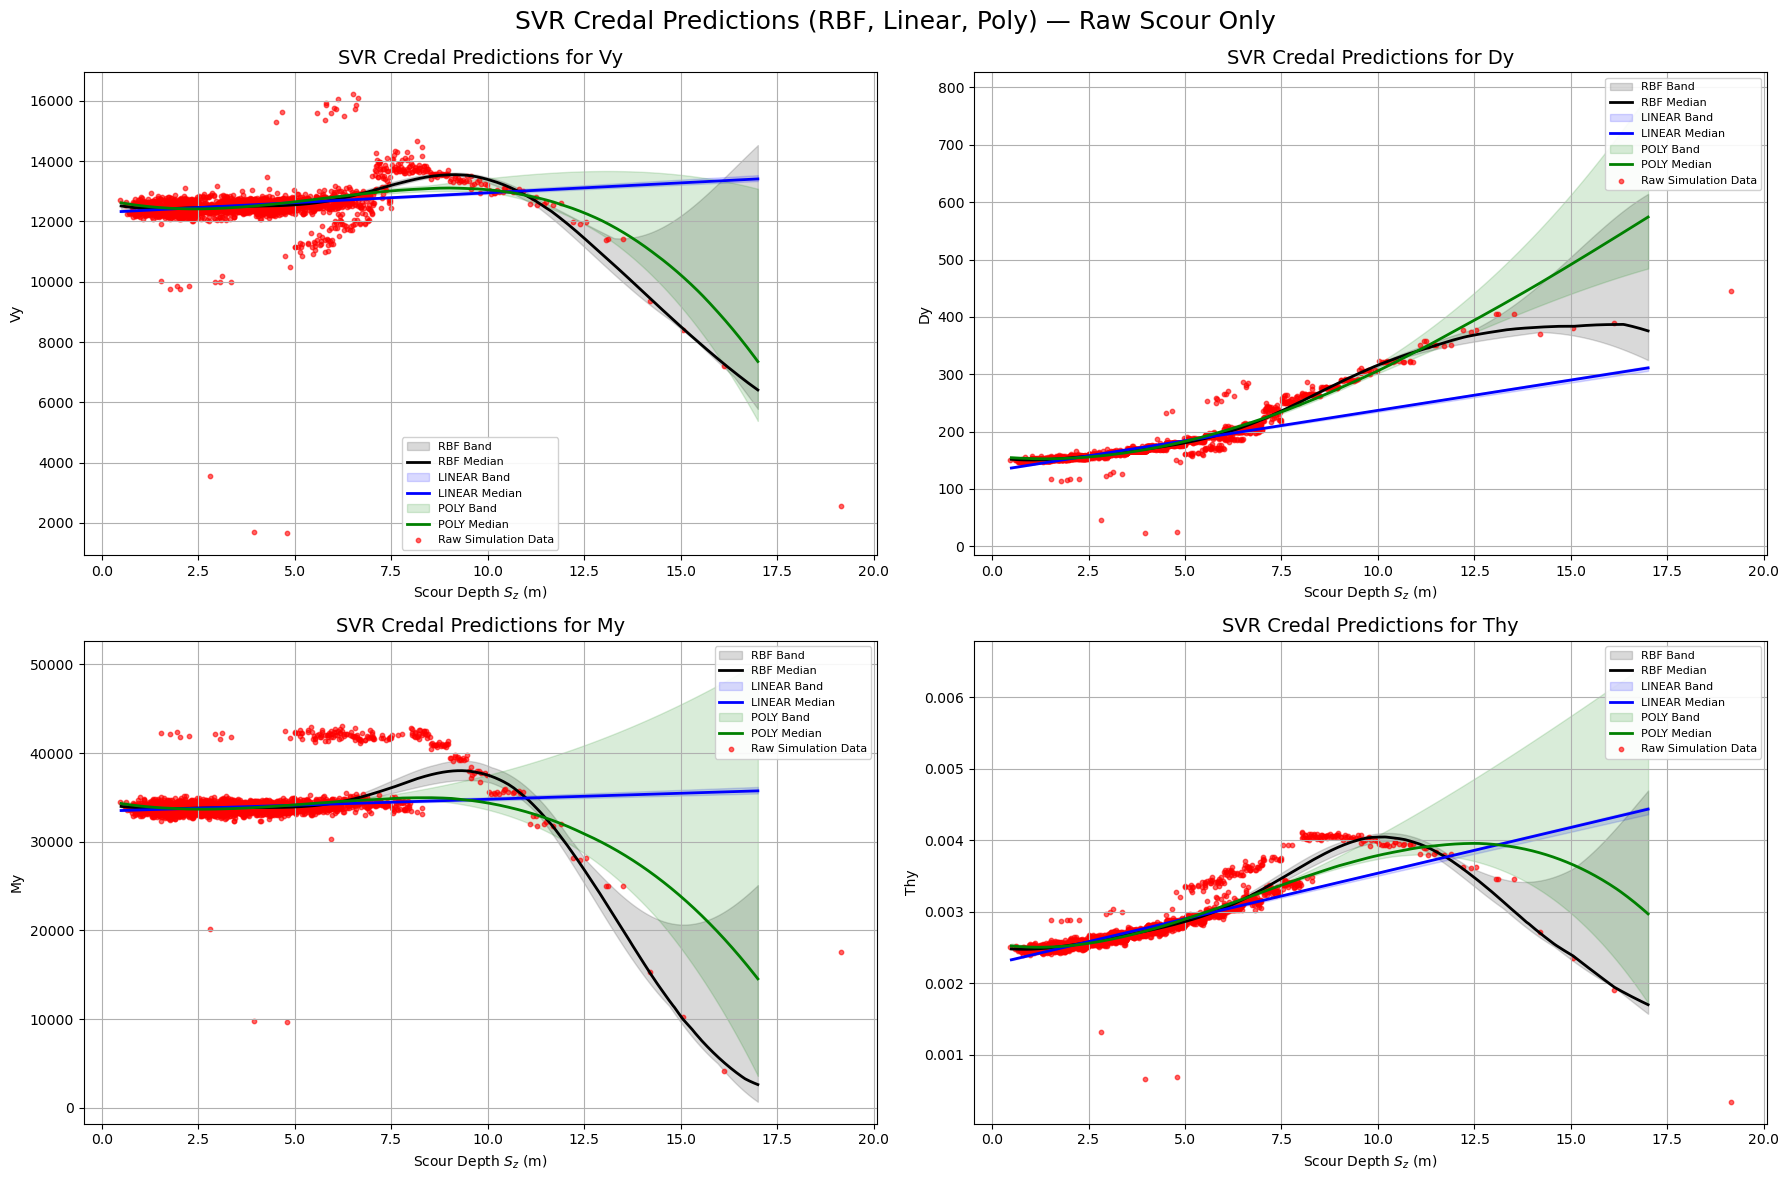

In [17]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
model_folder  = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR_raw_ScourOnly")
raw_data_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
targets       = ['Vy', 'Dy', 'My', 'Thy']
raw_cols      = ['Vy_kN', 'dy_mm', 'My_kNm', 'Thy_rad']
kernels       = ['rbf', 'linear', 'poly']  # Plot ALL kernels

kernel_colors = {
    "rbf": "black",
    "linear": "blue",
    "poly": "green"
}

# --- Load raw simulation data ---
df_raw = pd.concat(pd.read_excel(raw_data_path, sheet_name=None), ignore_index=True)

# --- Precompute Scour-only features ---
sz_m = np.linspace(0.5, 17, 1000)  # Scour depth in meters
X_scour = (sz_m * 1000).reshape(-1, 1)  # in mm

# --- Plot setup ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for ax, target, raw_col in zip(axes, targets, raw_cols):
    # Load scalers
    x_scaler = joblib.load(model_folder / f"x_scaler_{target}.pkl")
    y_scaler = joblib.load(model_folder / f"y_scaler_{target}.pkl")

    # Scale input once
    X_scaled = x_scaler.transform(X_scour)

    for kernel in kernels:
        # Load 30 bootstrapped models for this target and kernel
        models = [
            joblib.load(model_folder / f"credal_svr_{target}_{kernel}_boot{i}.pkl")
            for i in range(30)
        ]

        # Predict ensemble
        preds = np.stack([
            y_scaler.inverse_transform(m.predict(X_scaled).reshape(-1, 1)).ravel()
            for m in models
        ], axis=0)
        pred_lo, pred_hi = preds.min(axis=0), preds.max(axis=0)
        pred_med = np.median(preds, axis=0)

        # --- Plot for this kernel ---
        ax.fill_between(sz_m, pred_lo, pred_hi, alpha=0.15, label=f"{kernel.upper()} Band", color=kernel_colors[kernel])
        ax.plot(sz_m, pred_med, lw=2, label=f"{kernel.upper()} Median", color=kernel_colors[kernel])

    # Overlay raw simulation data
    ax.scatter(
        df_raw["Scour_Depth_mm"] / 1000,
        df_raw[raw_col],
        color='red', s=10, alpha=0.6, label="Raw Simulation Data"
    )

    # Decorations
    ax.set_title(f"SVR Credal Predictions for {target}", fontsize=14)
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(target)
    ax.grid(True)
    ax.legend(fontsize=8, frameon=True, fancybox=True, framealpha=0.9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("SVR Credal Predictions (RBF, Linear, Poly) — Raw Scour Only", fontsize=18)
plt.show()
